In [ ]:
%%capture
# Clone repository
!git clone https://github.com/clement-bonnet/Lazimpa.git
!mv "./Lazimpa/egg" "./egg"
!mv "./Lazimpa/example" "./example"
!mv "./Lazimpa/experiments" "./experiments"
!mkdir "analysis"
!mkdir images_dir
!pip install images2gif

EXPERIMENTS = ["not_impatient", "impatient", "not_impatient_nad", "impatient_nad"]

In [ ]:
# Useful functions (for analysis)

import os
import glob
from PIL import Image as PILImage
from IPython.display import Image as IPythonImage
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def load_message(expe):
    """
    Load messages stored during training procedure/
    Return numpy array with all the messages
    """
    np_load_old = np.load
    messages = np.load(expe,allow_pickle=True)
    np.load = np_load_old
    return messages

def img2gif(img_dir, output_file):
    """
    Transform a folder of images (img_dir) into a gif and save it with name output_file
    """
    # filepaths
    files = os.listdir(img_dir)
    files = [ _ for _ in files if ".png" in _ ]
    files = [int(_.split(".")[0]) for _ in files]
    files.sort()
    fp_in= [img_dir + f"/{_}.png" for _ in files]
    fp_out = output_file

    img, *imgs = [PILImage.open(f).resize((800,200)) for f in fp_in]
    img.save(fp=fp_out, format='GIF', append_images=imgs,
            save_all=True, duration=60, loop=0)

In [ ]:
# Analysis
def test_channel(train_dir, analysis_dir):
    receiver_weights = os.path.join(train_dir, "receiver/receiver_weights100.pth")
    sender_weights = os.path.join(train_dir, "sender/sender_weights100.pth")
    # analysis_dir = os.path.join(analysis_dir)
    !python -m egg.zoo.channel.test --impatient=True --save_dir=$analysis_dir --receiver_weights=$receiver_weights --sender_weights=$sender_weights --vocab_size=40  --max_len=30 --n_features=100 --sender_cell="lstm" --receiver_cell="lstm" --sender_hidden=250 --receiver_hidden=600 --receiver_embedding=100 --sender_embedding=10 --sender_num_layers=1 --receiver_num_layers=1

def position_analysis(train_dir, analysis_dir):
    receiver_weights = os.path.join(train_dir, "receiver/receiver_weights100.pth")
    sender_weights = os.path.join(train_dir, "sender/sender_weights100.pth")
    # analysis_dir = os.path.join(analysis_dir)
    !python -m egg.zoo.channel.position_analysis --save_dir=$analysis_dir --impatient=True --sender_weights=$sender_weights --receiver_weights=$receiver_weights --vocab_size=40 --n_features=100 --max_len=30 --sender_cell="lstm" --receiver_cell="lstm" --sender_hidden=250 --receiver_hidden=600 --receiver_embedding=100 --sender_embedding=10 --sender_num_layers=1 --receiver_num_layers=1

def do_analysis(train_dir, analysis_dir):
    test_channel(train_dir, analysis_dir)
    position_analysis(train_dir, analysis_dir)

get_train_dir = lambda experiment: f"experiments/dir_save_{experiment}/"
get_analysis_dir = lambda experiment: f"analysis/{experiment}/"

def plot_all(plot_function, mode="train_dir"):
    for experiment in EXPERIMENTS:
        if mode == "train_dir":
            train_dir = get_train_dir(experiment)
            plot_function(train_dir)
        elif mode == "analysis_dir":
            analysis_dir = get_analysis_dir(experiment)
            plot_function(analysis_dir)
        else:
            raise ValueError(f"mode '{mode}' not in ['train_dir', 'analysis_dir']")

In [ ]:
%%capture
# Do the analyses
for experiment in EXPERIMENTS:
    train_dir = get_train_dir(experiment)
    analysis_dir = get_analysis_dir(experiment)
    !mkdir $analysis_dir
    do_analysis(train_dir, analysis_dir)

### III-2. Analytical plots

**0. Number of consonant clusters:** Count number of consonant clusters of size 2 and 3 for each message

In [ ]:
def plot_consonant_clusters(train_dir):
    # Choose epochs (between 0 and 500)
    epochs=[1,90,100]

    for epoch in epochs:
        # Load messages
        message_path = os.path.join(train_dir, f"messages/messages_{epoch}.npy")
        messages=load_message(message_path)

        # Construct the length distribution
        clstr2=[] #count number of clsuters of size 2
        clstr3=[] #count number of clsuters of size 3
        
        for message in messages:
            ct2 = 0
            ct3 = 0
            for i in range(len(message)-2):
                # segment of size 2
                segment1 = message[i:i+2] 
                if (int(segment1[0]) < 27) and (int(segment1[1]) < 27):
                    ct2 += 1
                
                # segment of size 3
                segment2 = message[i:i+3]
                if (int(segment2[0]) < 27) and (int(segment2[1]) < 27) and (int(segment2[2]) < 27):
                    ct3 += 1

            # side case of size 2
            if len(message) > 1:
                if (int(message[-2]) < 27) and (int(message[-1]) < 27):
                    ct2 += 1
            
            clstr2.append(ct2)
            clstr3.append(ct3)

        # Add epoch to plot
        plt.figure(1)
        plt.plot(clstr2,label="Epoch "+str(epoch))

        plt.figure(2)
        plt.plot(clstr3,label="Epoch "+str(epoch))

    # Plot fig
    plt.figure(1)
    plt.title("Number of consonant clusters of size 2 as a function of inputs ranked by frequency")
    plt.xlabel("Inputs ranked by frequency")
    plt.ylabel("clusters of size 2")
    plt.xlim((0,100))
    plt.ylim((0,32))
    plt.legend()

    plt.figure(2)
    plt.title(f"Number of consonant clusters of size 3 as a function of inputs ranked by frequency - {train_dir}")
    plt.xlabel("Inputs ranked by frequency")
    plt.ylabel("clusters of size 3")
    plt.xlim((0,100))
    plt.ylim((0,32))
    plt.legend()

    plt.show()


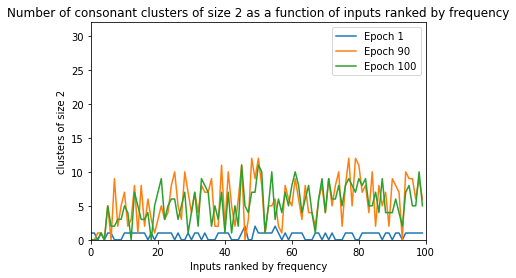

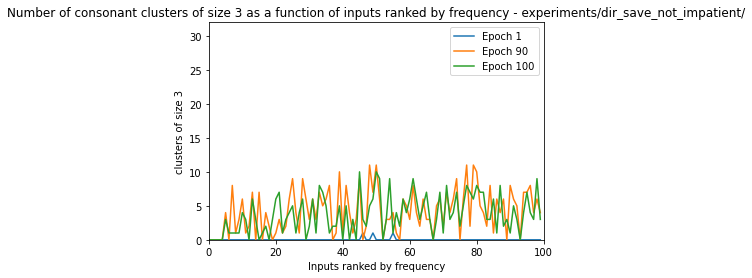

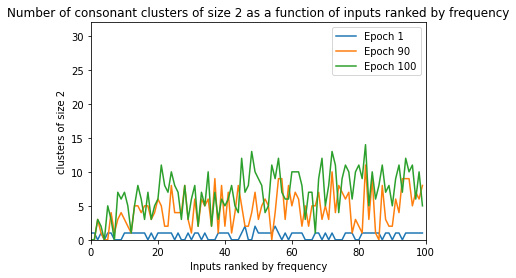

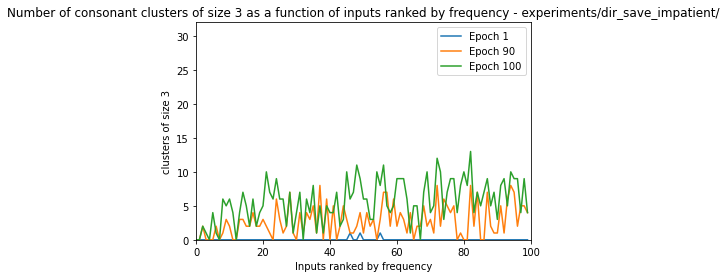

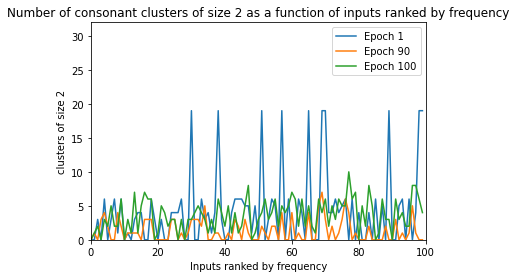

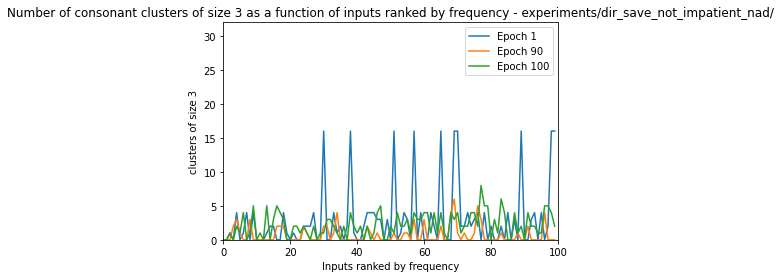

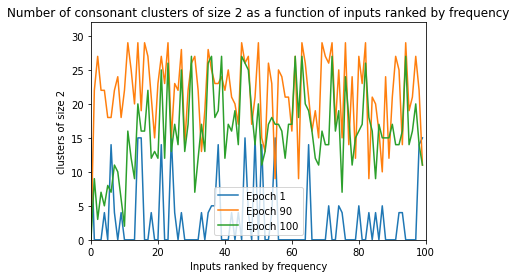

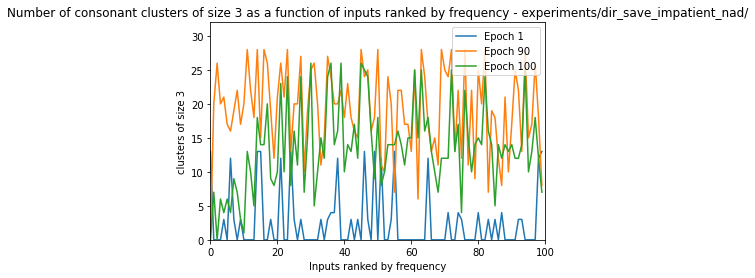

In [ ]:
plot_all(plot_consonant_clusters)

**1. Length distribution for different epochs:** length distribution converges almost toward Optimal coding

In [ ]:
def plot_length_distribution(train_dir):
    # Choose epochs (between 0 and 500)
    epochs=[1,50,90,95,100]

    for epoch in epochs:
        # Load messages
        message_path = os.path.join(train_dir, f"messages/messages_{epoch}.npy")
        messages=load_message(message_path)

        # Construct the length distribution
        length_distribution=[]
        for message in messages:
            length_distribution.append(len(message))

        # Add epoch to plot
        plt.plot(length_distribution,label="Epoch "+str(epoch))

    # Plot fig
    plt.title(f"Message length as a function of inputs ranked by frequency - {train_dir}")
    plt.xlabel("Inputs ranked by frequency")
    plt.ylabel("Message length")
    plt.xlim((0,100))
    plt.ylim((0,32))
    plt.legend()
    plt.show()


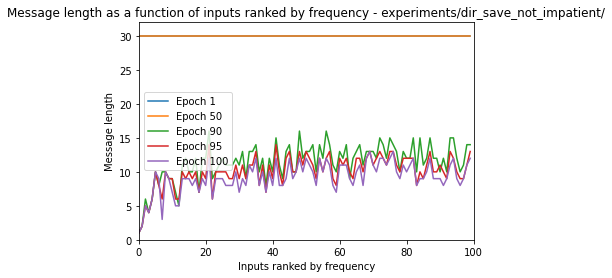

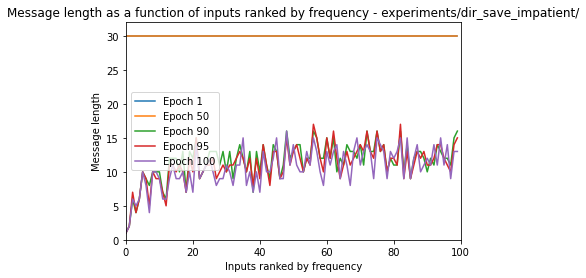

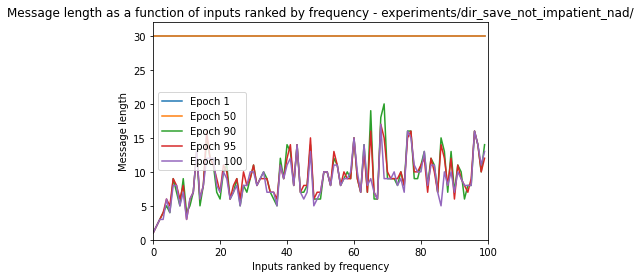

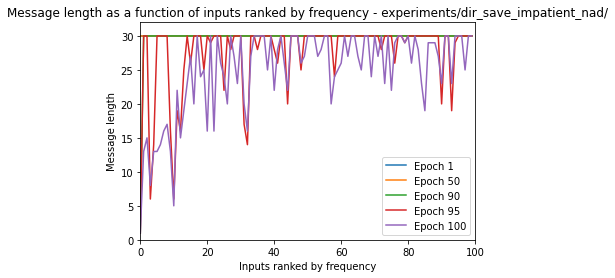

In [ ]:
plot_all(plot_length_distribution)

**2. Accuracy evolution**

In [ ]:
def plot_accuracy(train_dir, nb_epochs=500):
    # Get accuracy
    accuracy=[]
    for i in range(1, nb_epochs+1):
        accuracy_path = os.path.join(train_dir, "accuracy/accuracy_"+str(i)+".npy")
        accuracy.append(np.mean(np.load(accuracy_path)))
    # Plot fig
    fig, ax = plt.subplots(1, 1, figsize=(11,4))
    ax.plot(accuracy,label="LazImpa",c="tab:blue")
    ax.set_title(f"Accuracy evolution - {train_dir}")
    ax.set_xlabel("Training episodes")
    ax.set_ylabel("Accuracy")
    ax.set_xlim((0,nb_epochs))
    ax.set_ylim((-0.05, 1.05))
    plt.show()

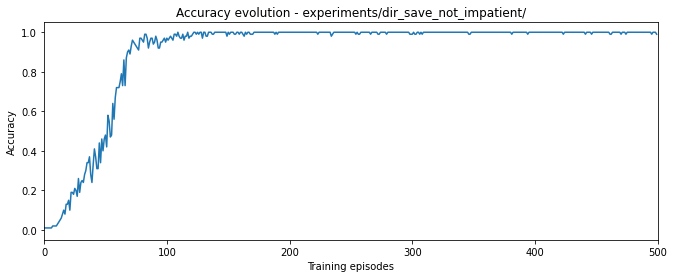

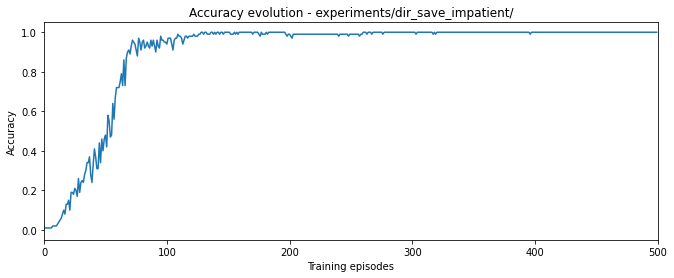

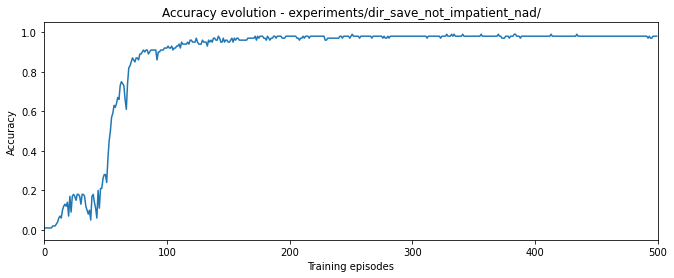

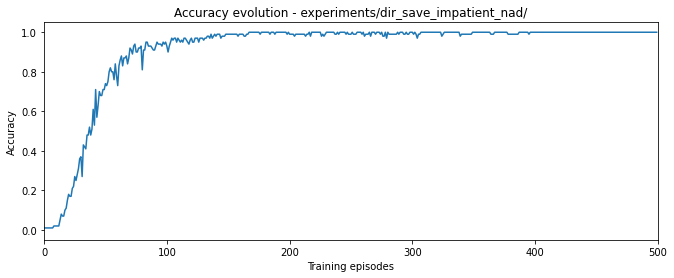

In [ ]:
plot_all(plot_accuracy)

**3. Mean length evolution**

In [ ]:
def plot_length_evolution(train_dir, nb_epochs=500):
    mean_length_evolution=[]
    for epoch in range(nb_epochs):
        # Load messages
        message_path = os.path.join(train_dir, f"messages/messages_{epoch}.npy")
        messages=load_message(message_path)

        # Construct the length distribution
        length_distribution=[]
        for message in messages:
            length_distribution.append(len(message))
    
        # Get the mean length
        mean_length_evolution.append(np.mean(length_distribution))

    # Plot fig
    fig, ax = plt.subplots(1, 1, figsize=(11,4))
    ax.plot(mean_length_evolution,label="LazImpa",c="tab:blue")
    ax.set_title(f"Mean length evolution - {train_dir}")
    ax.set_xlabel("Training episodes")
    ax.set_ylabel("Mean length")
    ax.set_xlim((0,nb_epochs))
    ax.set_ylim((0,31))

    plt.show()

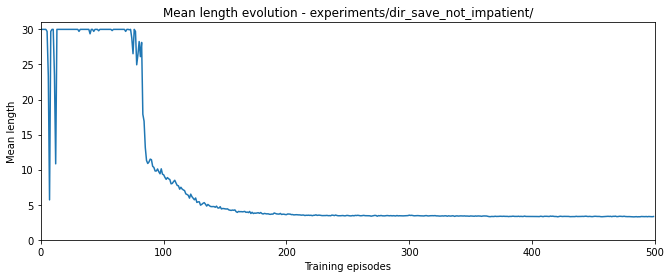

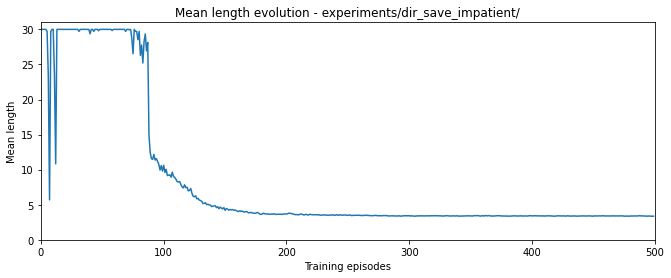

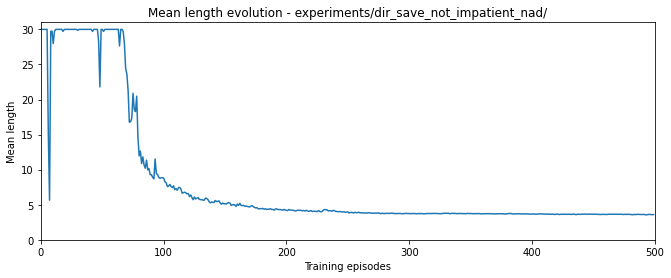

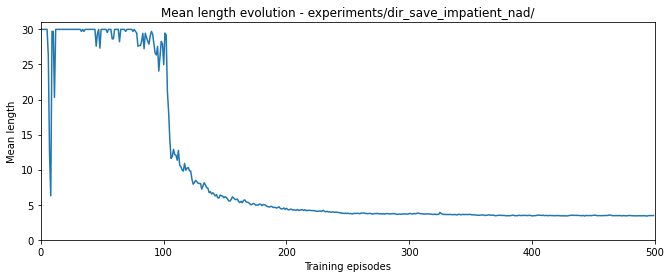

In [ ]:
plot_all(plot_length_evolution)

**4. Accuracy = f(mean_length)**: co-evolution of the accuracy and mean message length: allow us to spot the beginning of the regularization (laziness)

In [ ]:
def plot_accuracy_message_length(train_dir, nb_epochs=500):
    mean_length_evolution=[]
    accuracy=[]

    for epoch in range(nb_epochs):
        # Load messages
        message_path = os.path.join(train_dir, f"messages/messages_{epoch}.npy")
        messages=load_message(message_path)

        # Construct the length distribution
        length_distribution=[]
        for message in messages:
            length_distribution.append(len(message))
        
        # Get the mean length
        mean_length_evolution.append(np.mean(length_distribution))

        # Get the accuracy
        accuracy_path = os.path.join(train_dir, "accuracy/accuracy_"+str(epoch)+".npy")
        accuracy.append(np.mean(np.load(accuracy_path)))

    # Plot fig
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    ax.scatter(mean_length_evolution,accuracy,s=2.5)
    ax.set_title(f"Accuracy= f(mean message length) - {train_dir}")
    ax.set_xlabel("Mean message length")
    ax.set_ylabel("Accuracy")
    ax.set_xlim((0,31))
    ax.set_ylim((-0.05, 1.05))

    plt.show()

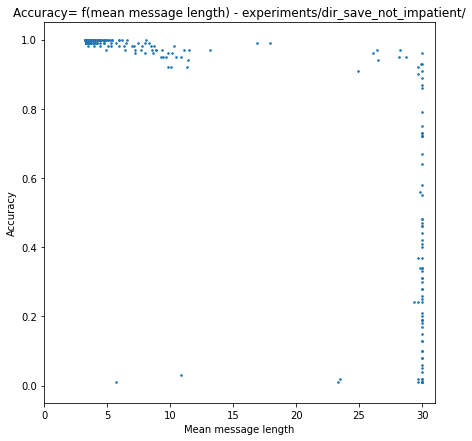

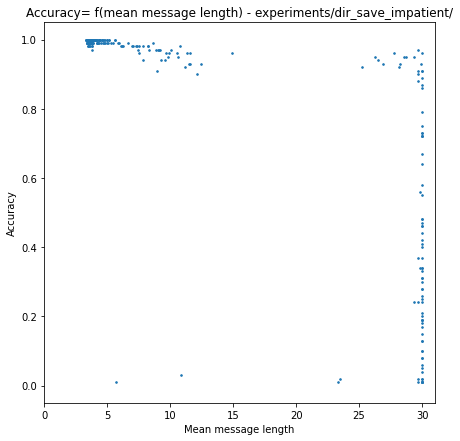

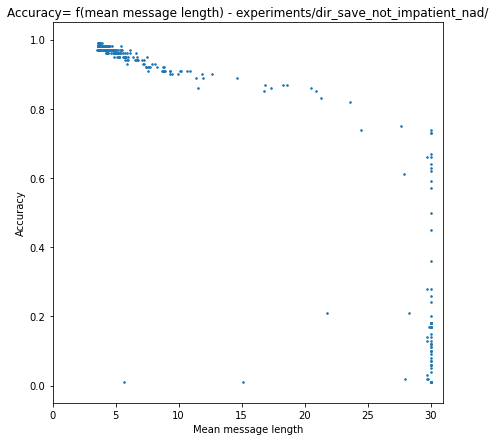

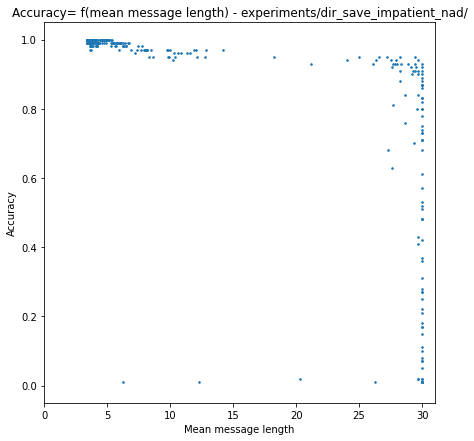

In [ ]:
plot_all(plot_accuracy_message_length)

**5. Position of informative symbols**: allows us to see where informative symbols are set within the messages

legend:
- yellow: uninformative ; 1: informative; purple: no symbol
- 1: uninformative ; 0: informative ; -1 no symbol

In [ ]:
def plot_informative_symbols(analysis_dir):
    # Color the matrix of "information test"
    analysis_path = os.path.join(analysis_dir, "position_sieve.npy")
    plt.matshow(np.load(analysis_path))
    plt.xlabel("Position")
    plt.ylabel("Message (ranked by frequency)")
    plt.title(f"Position of informative symbols - {analysis_dir}")
    plt.show()

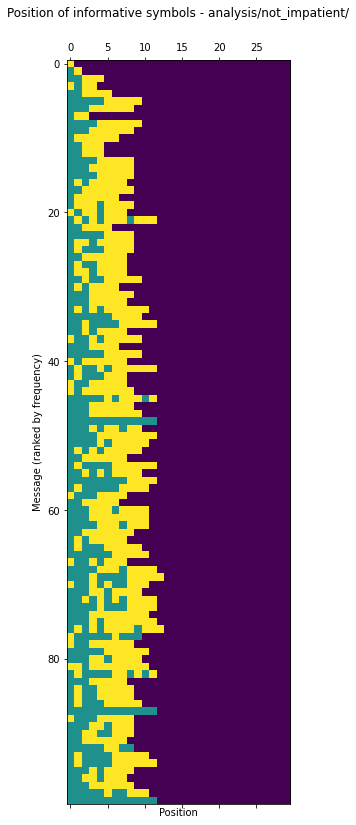

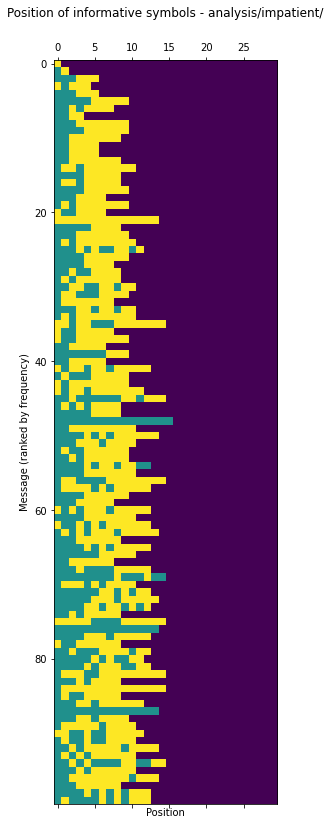

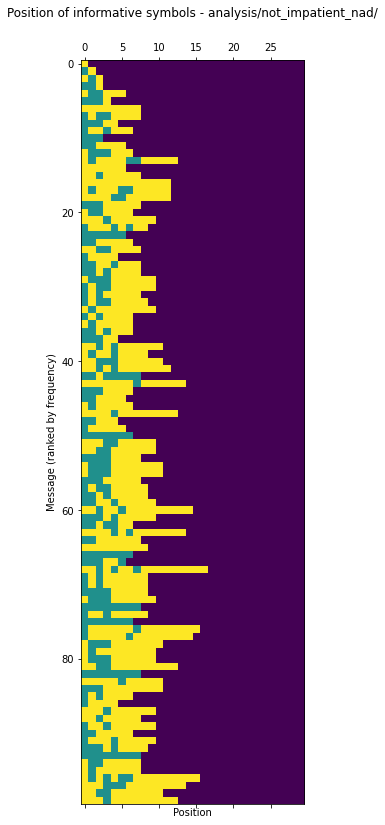

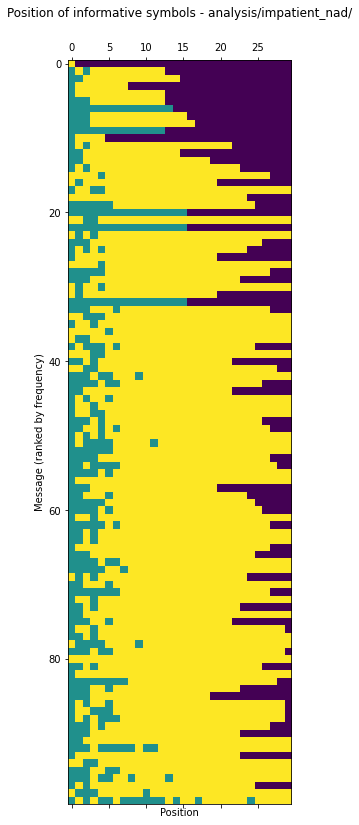

In [ ]:
plot_all(plot_informative_symbols, mode="analysis_dir")

**6. Dynamic evolution of the training**: (takes a few minutes to run)

Create gif

In [ ]:
def create_gif(train_dir, nb_epochs=500, plot_every=10):
    # Create gif
    experiment = '_'.join(train_dir.split('/')[1].split('_')[2:])
    image_dir = os.path.join("images_dir", experiment)
    !mkdir $image_dir

    accuracy_lazimpa=[]
    mean_len_lazimpa=[]
    accuracy_normal=[]
    mean_len_normal=[]
    accuracy_impatient=[]
    mean_len_impatient=[]
    accuracy_normreg=[]
    mean_len_normreg=[]

    range_ = range(plot_every, nb_epochs+1, plot_every)
    for index, i in enumerate(range_):
        message_path = os.path.join(train_dir, f"messages/messages_{i}.npy")
        messages_lazimpa = load_message(message_path)

        L_lazimpa=[]

        for m in messages_lazimpa:
            L_lazimpa.append(len(m))
        
        mean_len_lazimpa.append(np.mean(L_lazimpa))
        accuracy_path = os.path.join(train_dir, "accuracy/accuracy_"+str(i)+".npy")
        accuracy_lazimpa.append(np.mean(np.load(accuracy_path)))

        fig, axs = plt.subplots(1, 3, figsize=(11,4))
        axs[0].plot(L_lazimpa, label="LazImpa", c="tab:blue")
        axs[0].set_ylim((0,32))
        axs[0].set_xlabel("Input ranked by frequency")
        axs[0].set_ylabel("Message length") 
        axs[0].set_title(f"Length distribution {experiment}") 

        axs[1].plot(range_[:index+1], accuracy_lazimpa, label="LazImpa", c="tab:blue")
        axs[1].set_xlabel("Training episodes")
        axs[1].set_ylabel("Accuracy")
        axs[1].set_title(f"Accuracy evolution {experiment}")
        axs[1].set_xlim((0,nb_epochs))
        axs[1].set_ylim((-0.05, 1.05))

        axs[2].plot(range_[:index+1], mean_len_lazimpa,label="LazImpa",c="tab:blue")
        axs[2].set_xlabel("Training episodes")
        axs[2].set_ylabel("Mean message length")
        axs[2].set_title(f"Mean length evolution {experiment}")
        axs[2].set_xlim((0,nb_epochs))
        axs[2].set_ylim((0,32))

        fig.tight_layout(pad=2.5)

        fig.suptitle("Episode "+str(i))
        save_path = os.path.join(image_dir, f"{i}.png")
        plt.savefig(save_path)
        plt.close() 

    output_gif_path = os.path.join(get_analysis_dir(experiment), "training_dynamic.gif")
    img2gif(image_dir, output_gif_path)

def create_all_gif(nb_epochs=500, plot_every=10):
    for experiment in EXPERIMENTS:
        train_dir = get_train_dir(experiment)
        create_gif(train_dir, nb_epochs=nb_epochs, plot_every=plot_every)

In [ ]:
%%capture
create_all_gif(nb_epochs=500, plot_every=10)

Display gif

In [ ]:
def display_gif(experiment):
    analysis_dir = get_analysis_dir(experiment)
    gif_file = os.path.join(analysis_dir, 'training_dynamic.gif')
    with open(gif_file, 'rb') as f:
        display(IPythonImage(data=f.read(), format='png'))

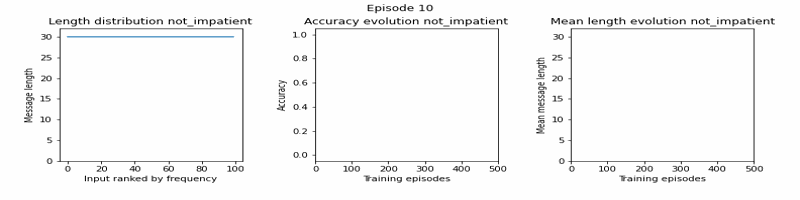

In [ ]:
display_gif(EXPERIMENTS[0])

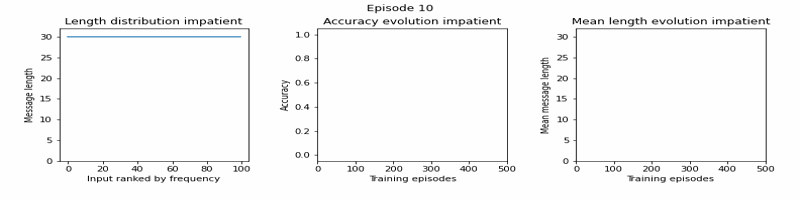

In [ ]:
display_gif(EXPERIMENTS[1])

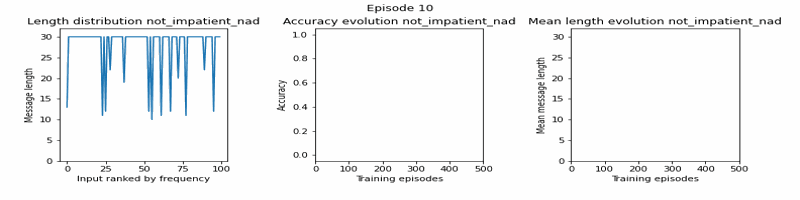

In [ ]:
display_gif(EXPERIMENTS[2])

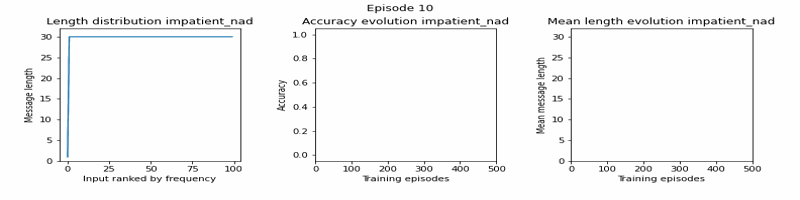

In [ ]:
display_gif(EXPERIMENTS[3])

Compare all plots

In [ ]:
image_dir = os.path.join("images_dir", "impatient")

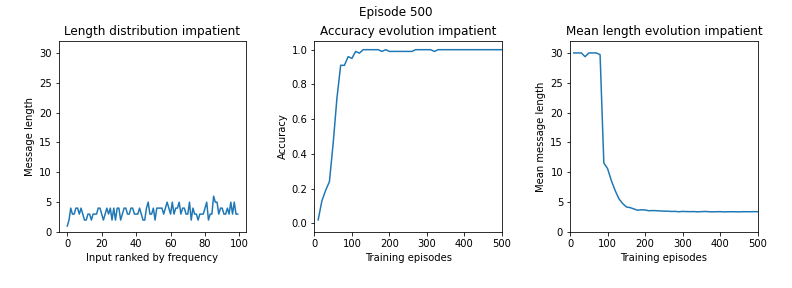

In [ ]:
IPythonImage(os.path.join(image_dir, "500.png"))

In [ ]:
def plot_compare_all(epoch=500):
    plt.figure(figsize=(20, int(4.5*len(EXPERIMENTS))))
    for i, experiment in enumerate(EXPERIMENTS):
        plt.subplot(len(EXPERIMENTS), 1, i+1)
        image_dir = os.path.join("images_dir", experiment)
        img = mpimg.imread(os.path.join(image_dir, f"{epoch}.png"))
        plt.imshow(img)
    plt.tight_layout()

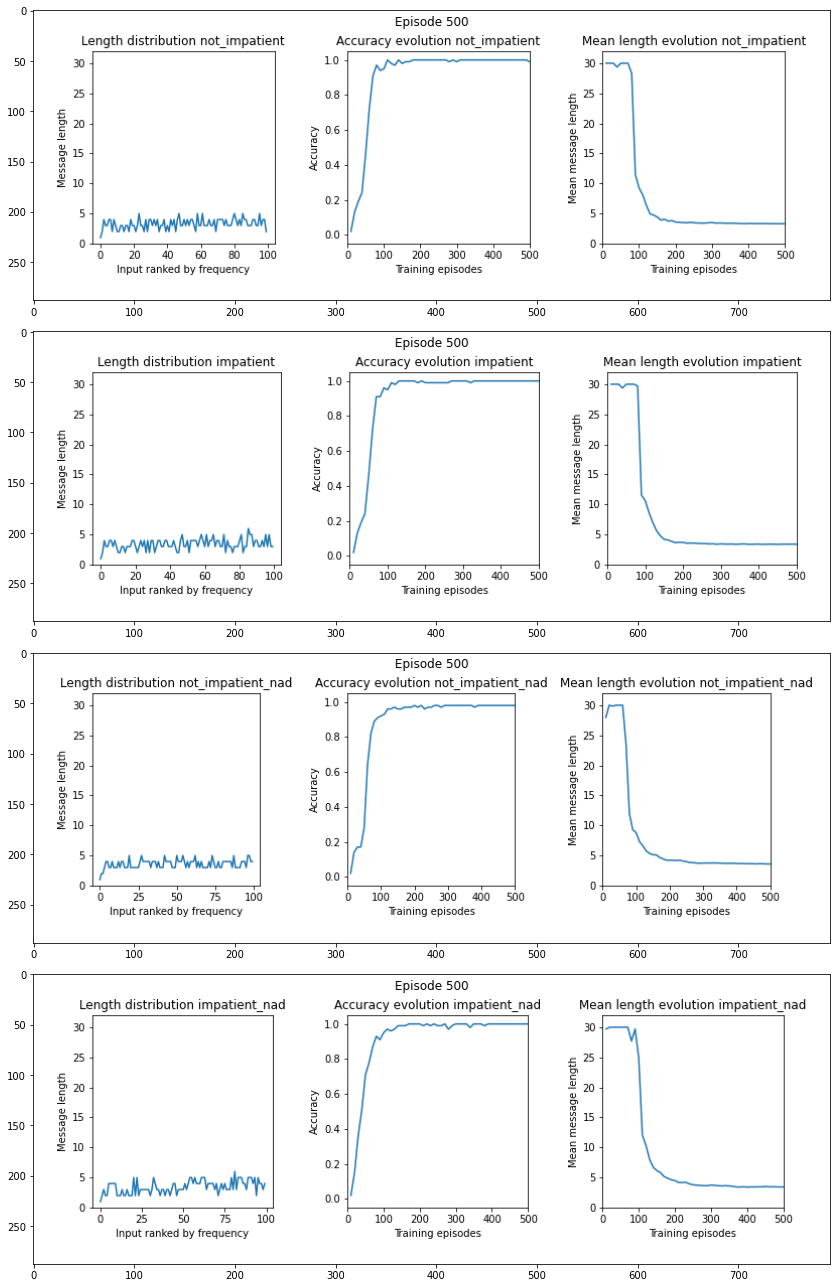

In [ ]:
plot_compare_all(epoch=500)